In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.31.0
BeautifulSoup   4.12.3


In [2]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [3]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [4]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [5]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [6]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [7]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [8]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [9]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


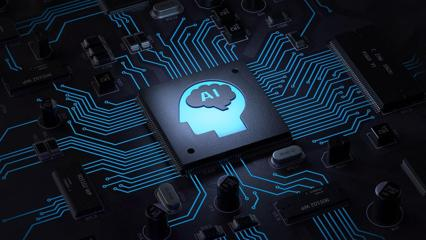

[How BCG is transforming consulting with AI.](https://www.forbes.com/sites/bernardmarr/2024/07/10/how-bcg-is-revolutionizing-consulting-with-ai-a-case-study/) - Forbes

___

[Elon Musk snarks at Sam Altman over his pricey car.

2 power-hungry lunatics, 1 seems smarmy and self-serving, 1 always seems to be in a one-sided pissing match with everybody.](https://x.com/elonmusk/status/1810901569006883096) - X (formerly Twitter)

___

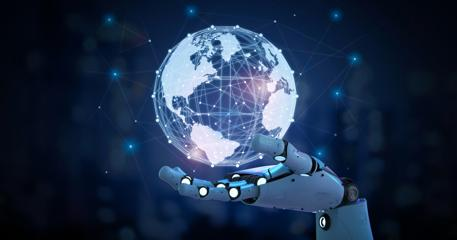

[World AI conference declaration echoes Asimov's laws of robotics.](https://newatlas.com/technology/china-artificial-intelliegencei-guideline-humanity-first/) - New Atlas

___

[The Babelfish is here.](https://www.theregister.com/2024/07/10/timekettle_x1_ai_interpreter_hub/)

___

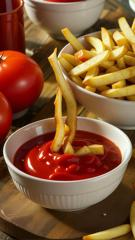

[Dancing french fries go viral](https://www.youtube.com/watch?v=D8RpE_JDpOA) - YouTube

___

An interview with Meta's CTO about AR and the metaverse.

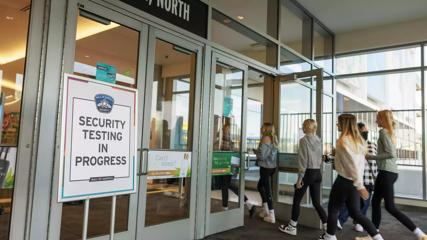

[Mall of America adds facial recognition. 

(Same company's mall near NY is very troubled, news that American Dream is going bankrupt seems apt)](https://www.mprnews.org/story/2024/07/09/new-ai-security-measure-at-mall-of-america-raises-concerns-for-some) - MPR News

___

[Lee Saedol talks about losing to AI, and how a lot of people are going to be surprised to find out AI is better than them at stuff they care about and poured themselves into.](https://www.nytimes.com/2024/07/10/world/asia/lee-saedol-go-ai.html)

___

[Bill Gates writes about seeing Khanmigo in use on a field trip to Newark schools.](https://www.gatesnotes.com/My-trip-to-the-frontier-of-AI-education)

___

[The spending on Nvidia is unsustainable, so it will not be sustained LOL.](https://www.bloomberg.com/opinion/articles/2024-07-10/will-ai-ever-pay-off-venture-capitalists-footing-the-bill-are-worrying-already)

___

Sometimes there are Googles and you want to get in early and hold forever, and not worry too much if the price gets a couple of years ahead of reality if you want to hold for decades. But sometimes there are boom-and-bust situations like AOL, or TheGlobe, or Cisco comparison seems very on point.

[I wrote something similar a while back in a CFA Institute blog post.](https://druce.ai/2013/08/risk-arbitrage-investing-and-poker/) - Druce.ai

___

[Passive investors and the AI bubble. I don't really agree with the premises of the thought experiment. In a real market there is no freeze, more passive investors make the market  marginally thinner and more vulnerable to the herd stampeding. It is complicated though.](https://www.ft.com/content/201d1234-58cc-40a1-be46-b1820f63ccee)

___

[Microsoft and Apple give up OpenAI board observer seats amid antitrust scrutiny.](https://www.ft.com/content/ecfa69df-5d1c-4177-9b14-a3a73072db12)

___

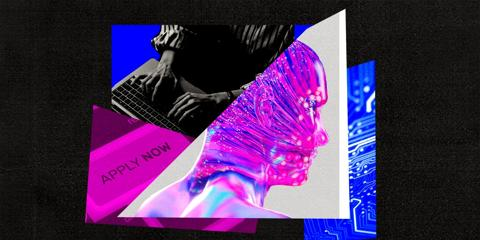

[AI 'magical teleprompter' helpers listen in to job interviews and give candidates hints in real-time.](https://www.businessinsider.com/ai-job-interview-tools-final-round-otter-2024-7) - Business Insider

___

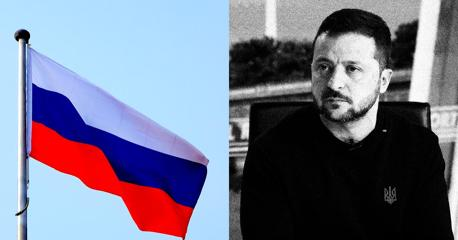

[How Disinformation From a Russian AI Spam Farm Ended up on Top of Google Search Results](https://www.wired.com/story/ai-generated-russian-disinformation-zelensky-bugatti/) - WIRED

___

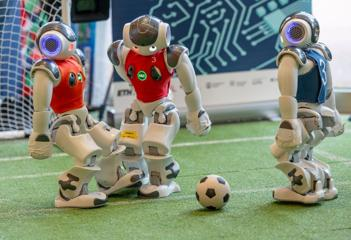

[AI startup funding more than doubles from a year ago in Q2,  up 16% sequentially, Crunchbase data shows](https://finance.yahoo.com/news/ai-startup-funding-more-doubles-122445641.html) - Yahoo Finance

___

[Why conscious AI would experience beauty. 

Does Midjourney experience beauty?](https://3quarksdaily.com/3quarksdaily/2024/07/why-conscious-ai-would-experience-beauty.html)

___

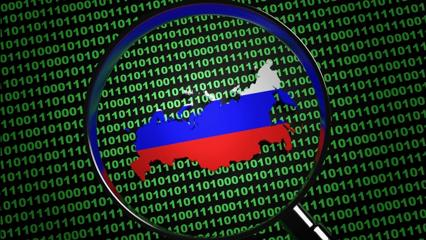

[US crashes Russian bot farm that used AI to spread propaganda.](https://www.pcmag.com/news/us-disrupts-russian-bots-spreading-propaganda-on-twitter) - PCMAG

___

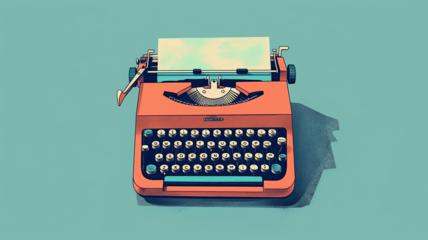

[Writer drops graph-based enterprise RAG.](https://venturebeat.com/ai/writer-drops-mind-blowing-ai-update-rag-on-steroids-10m-word-capacity-and-ai-thought-process-revealed/) - VentureBeat

___

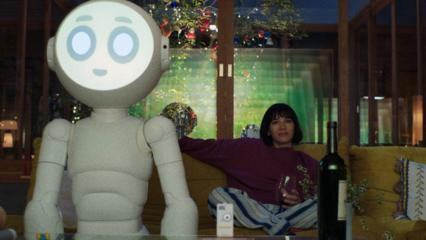

[Rashida Jones in offbeat robot drama-thriller-buddy comedy set in Japan on Apple TV.](https://www.rollingstone.com/tv-movies/tv-movie-reviews/rashida-jones-sunny-robot-ai-1235051472/) - Rolling Stone

___

[Washington Post added an AI chatbot to answer user questions about climate.](https://www.axios.com/2024/07/09/washington-post-ai-chatbot-climate)

___

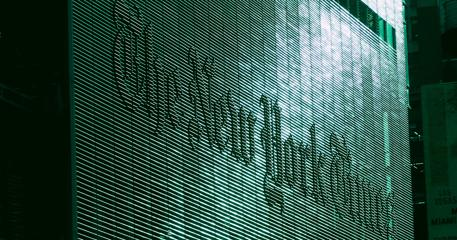

[NYT code leak shows they experimented with AI for headline writing, copy editing. Didn't explain opinion page shenanigans.](https://futurism.com/new-york-times-chatgpt-headlines) - Futurism

___

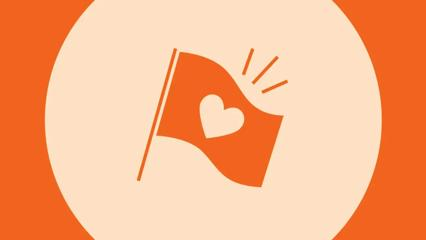

[Etsy adds labeling requirements to thwart influx of AI-designed slop.](https://lifehacker.com/tech/etsy-ai-policy) - Lifehacker

___

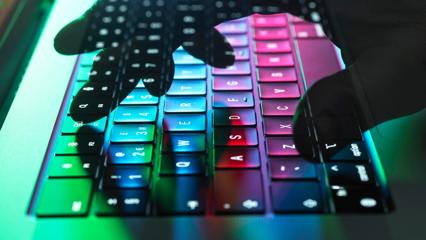

[Scammers use AI to post fake job ads to steal applicants' identities.](https://www.cnet.com/tech/scammers-are-creating-tons-of-fake-job-listings-thanks-to-ai/) - CNET

___

[Musk's xAI will buy its own GPUs instead of renting from Oracle.](https://www.theinformation.com/articles/musks-xai-and-oracle-end-talks-on-a-server-deal)

___

[Giant foreheads build a giant GPU hoard to entice startups.](https://www.theinformation.com/articles/andreessen-horowitz-is-building-a-stash-of-more-than-20-000-gpus-to-win-ai-deals)

___

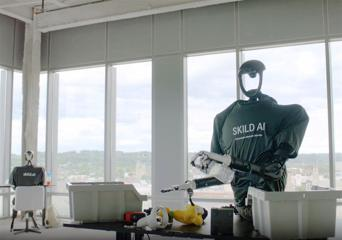

[CMU spinout Skild raises \\$300m from top investors for robot brains.](https://www.post-gazette.com/business/tech-news/2024/07/09/pittsburgh-ai-robotics-skild-ai-bezos/stories/202407090100) - Pittsburgh Post-Gazette

___

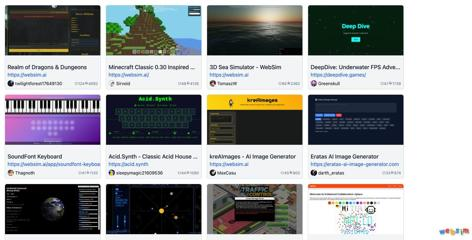

[Creating a website with Websim AI — here's how it works](https://www.tomsguide.com/how-to-use-websim) - Tom's Guide

___

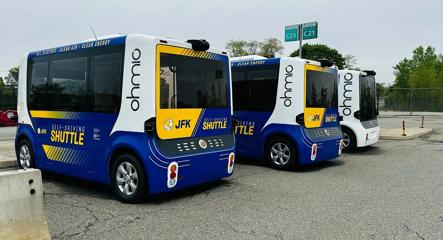

[Autonomous vehicles to shuttle JFK passengers from the Airtrain to their vehicle in the parking lot.](https://gothamist.com/news/jfk-airports-newest-ride-not-planes-but-self-driving-shuttles?utm_source=sfmc&utm_medium=nypr-email&utm_campaign=Newsletter+-+Early+Addition+-+20240709&utm_term=driverless+shuttle+bus+at+JFK+Airport+next+week.%26nbsp;&utm_id=349996&sfmc_id=54301869&utm_content=202479&nypr_member=Unknown) - Gothamist

___

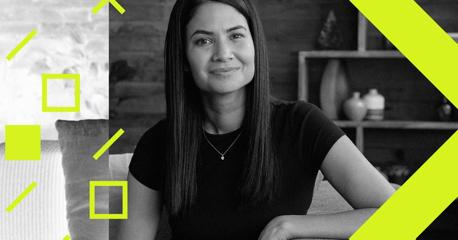

[Canva blocks the use of its AI to design political, medical, adult, financial or legal images.](https://www.theverge.com/24191080/canva-ceo-melanie-perkins-design-ai-adobe-competition-decoder-podcast-interview) - The Verge

___

[Used to be you had to go massively viral to raise like \\$10m, now you raise \\$60m at \\$500m valuation before you even release an app that demonstrates product-market fit.](https://www.bloomberg.com/news/articles/2024-07-09/ai-video-startup-is-valued-at-500-million-in-new-funding-round)

___

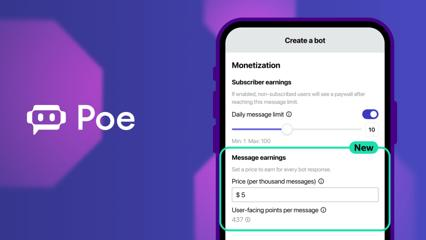

[Poe lets you create and share apps made with ChatGPT.](https://techcrunch.com/2024/07/08/quoras-poe-now-lets-users-create-and-share-web-apps/) - TechCrunch

___

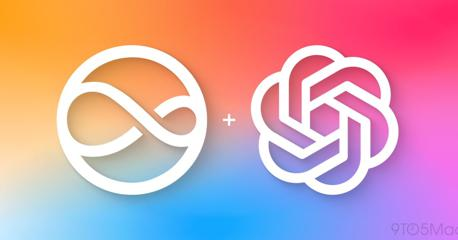

[Siri's ChatGPT makeover won't be here until Spring 2025 but should be a big improvement.](https://9to5mac.com/2024/07/08/everything-you-should-know-about-chatgpts-siri-integration-in-ios-18/) - 9to5Mac

___

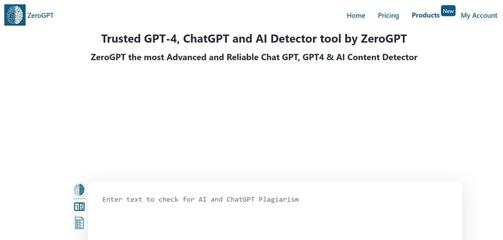

[AI detection is kind of BS. Small changes will defeat it, and better AI will inevitably be able to learn make those changes.](https://hackernoon.com/bypass-zerogpt-10-secrets-to-beat-zerogpt-ai-detection)

___

[Google stops buying cheap carbon offsets which are a scam, will buy carbon-removal offsets, but no longer claim carbon neutrality. Which is just being honest. Carbon credits cannot possibly be realistically enforced globally, they are casino capitalism flimflam. Tax carbon at the source or STFU.](https://www.bloomberg.com/news/articles/2024-07-08/google-is-no-longer-claiming-to-be-carbon-neutral)

___

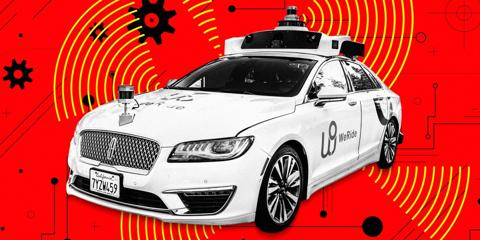

[China has autonomous vehicles surveying US roads. Wait til you hear about all the robovacs surveying US homes and all the surveillance cameras, IOT devices and smartphones.](https://fortune.com/2024/07/08/chinese-self-driving-cars-us-roads-data-collection-surveillance-national-security-concerns-investigation/) - Fortune

___

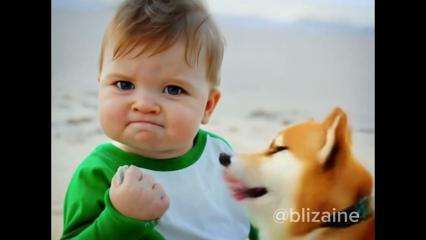

[The meme multiverse](https://www.youtube.com/watch?v=PXdgbS_iCzA) - YouTube

___

[OpenAI, Ariana Huffington partner on AI wellness coach.](https://thehill.com/policy/technology/4759481-sam-altman-arianna-huffington-ai-health-app/)

___

Groq is taking off, API flies with latest open-source LLMs, developers climb aboard.

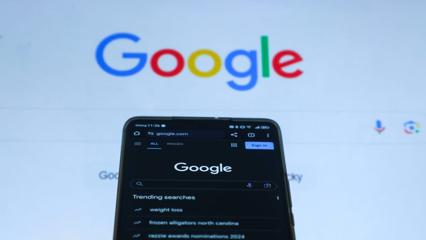

[Google search share rises a bit, ChatGPT traffic falls a bit.](https://qz.com/google-search-market-dominance-chatgpt-traffic-ai-1851580904) - Quartz

___

[WTF did I just watch](https://www.reddit.com/r/ChatGPT/comments/1dyb2bq/unanswered_oddities_aigenerated_tv_show/)

___

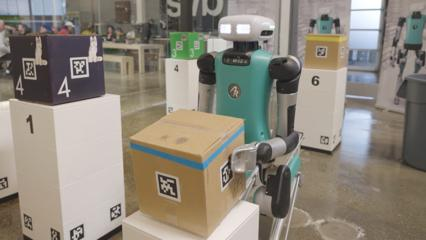

[Robots rise.](https://www.cnbc.com/2024/07/08/why-amazon-tesla-and-microsoft-are-investing-in-ai-powered-robots.html) - CNBC

___

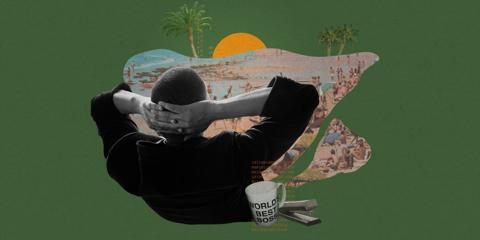

[How to use AI to help plan your vacation.](https://www.technologyreview.com/2024/07/08/1094733/how-to-use-ai-to-plan-your-next-vacation/) - MIT Technology Review

___

[AI lifts paychecks for CIOs.](https://www.wsj.com/articles/artificial-intelligence-boom-lifts-paychecks-for-cios-e1527eab)

___

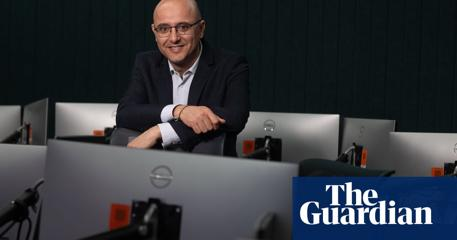

[Phone companies divert scam calls to AI bots. The future is weird.](https://www.theguardian.com/technology/article/2024/jul/07/ai-chatbots-phone-scams) - the Guardian

___

[NYT says SpaceX runs roughshod over environmental protections at Texas facility.](https://www.nytimes.com/2024/07/07/us/politics/spacex-wildlife-texas.html)

___

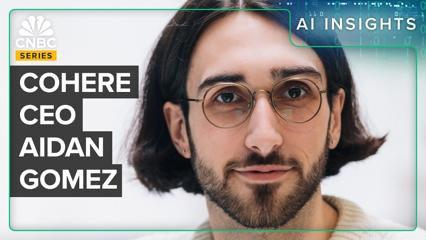

[Aiden Gomez of Cohere, fresh off of raising from Nvidia at a \\$5b valuation, says scale laws will keep on bearing fruit and progress will only get faster.](https://www.youtube.com/watch?v=ZFmapxYBafY) - YouTube

___

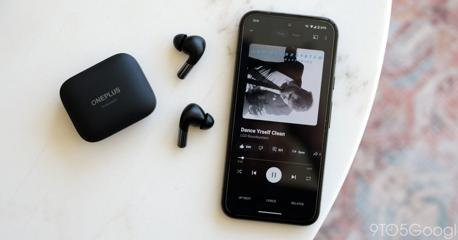

[YouTube testing AI DJ.](https://9to5google.com/2024/07/07/youtube-music-ai-radio/) - 9to5Google

___

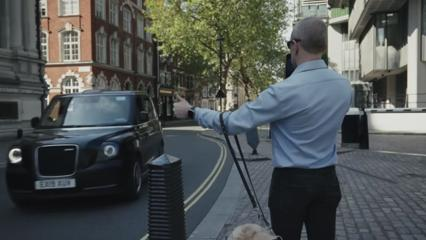

[AI is a boon for accessibility.](https://www.cnn.com/2024/07/08/tech/ai-assistive-technology-disabilities) - CNN

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [10]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [11]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 7, 10, 14, 56, 29, 843000)

In [12]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-07-09 04:57:53.066320


In [13]:
sqlite

NameError: name 'sqlite' is not defined